In [1]:
import os
import cv2
import time
import random
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from keras import applications, layers, losses, optimizers, metrics, Model
from keras.applications import resnet
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, VGG16, EfficientNetB0, MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
warnings.filterwarnings("ignore")
tf.__version__, np.__version__

('2.6.2', '1.20.3')

In [2]:
train_dir = "/kaggle/input/plant-project-dataset/Project Data/Train/images"
validation_dir = '/kaggle/input/plant-project-dataset/Project Data/Val/images'
xception_weights = '/kaggle/input/xception_weights/keras/default/1/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
classification_model_path = '/kaggle/input/classification_xception/keras/default/1/Xception_best_weights.h5'
weights_path = "/kaggle/working/siamese_model-final_93_84.weights.h5"

# Data perparing

## Read image paths

In [3]:
def print_folders(path):
  for folder in os.listdir(path):
    print(folder)

In [4]:
print_folders(train_dir)

Tomato___Late_blight
Tomato___healthy
Grape___healthy
Potato___healthy
Corn_(maize)___Northern_Leaf_Blight
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Strawberry___Leaf_scorch
Peach___healthy
Apple___Apple_scab
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Apple___Black_rot
Cherry_(including_sour)___Powdery_mildew
Peach___Bacterial_spot
Apple___Cedar_apple_rust
Tomato___Target_Spot
Pepper,_bell___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Potato___Late_blight
Tomato___Tomato_mosaic_virus
Strawberry___healthy
Apple___healthy
Grape___Black_rot
Potato___Early_blight
Cherry_(including_sour)___healthy
Corn_(maize)___Common_rust_
Grape___Esca_(Black_Measles)
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
Pepper,_bell___Bacterial_spot
Corn_(maize)___healthy


In [5]:
print_folders(validation_dir)

Tomato___Late_blight
Tomato___healthy
Grape___healthy
Potato___healthy
Corn_(maize)___Northern_Leaf_Blight
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Strawberry___Leaf_scorch
Peach___healthy
Apple___Apple_scab
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Apple___Black_rot
Cherry_(including_sour)___Powdery_mildew
Peach___Bacterial_spot
Apple___Cedar_apple_rust
Tomato___Target_Spot
Pepper,_bell___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Potato___Late_blight
Tomato___Tomato_mosaic_virus
Strawberry___healthy
Apple___healthy
Grape___Black_rot
Potato___Early_blight
Cherry_(including_sour)___healthy
Corn_(maize)___Common_rust_
Grape___Esca_(Black_Measles)
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
Pepper,_bell___Bacterial_spot
Corn_(maize)___healthy


In [6]:
def get_plant_name(plant_disease_name):
  return plant_disease_name.partition('___')[0]

Classes = {}
for folder in os.listdir(train_dir):
  Classes[folder] = get_plant_name(folder)

In [7]:
plant_disease = {}
for folder in os.listdir(train_dir):
    plant = Classes[folder]
    if plant not in plant_disease.keys():
      plant_disease[plant] = []
    plant_disease[plant].append(folder)
print(plant_disease)

{'Tomato': ['Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite'], 'Grape': ['Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)'], 'Potato': ['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight'], 'Corn_(maize)': ['Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy'], 'Strawberry': ['Strawberry___Leaf_scorch', 'Strawberry___healthy'], 'Peach': ['Peach___healthy', 'Peach___Bacterial_spot'], 'Apple': ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'], 'Cherry_(including_sour)': ['Cherry_(including_sour)___Powdery_mildew', 'Cherry_(includi

In [ ]:
def get_image_paths(dir):
  images = {}
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    images[folder] = []
    for image in os.listdir(folder_path):
      images[folder].append(os.path.join(folder_path, image))
  return images

In [9]:
train_images = get_image_paths(train_dir)
val_images = get_image_paths(validation_dir)

print(len(train_images.keys()))
for c, l in train_images.items():
    print(len(l), c)
print('\n')

print(len(val_images.keys()))
for c, l in val_images.items():
    print(len(l), c)

33
40 Tomato___Late_blight
40 Tomato___healthy
40 Grape___healthy
40 Potato___healthy
40 Corn_(maize)___Northern_Leaf_Blight
40 Tomato___Early_blight
40 Tomato___Septoria_leaf_spot
40 Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
40 Strawberry___Leaf_scorch
40 Peach___healthy
40 Apple___Apple_scab
40 Tomato___Tomato_Yellow_Leaf_Curl_Virus
40 Tomato___Bacterial_spot
40 Apple___Black_rot
40 Cherry_(including_sour)___Powdery_mildew
40 Peach___Bacterial_spot
40 Apple___Cedar_apple_rust
40 Tomato___Target_Spot
40 Pepper,_bell___healthy
40 Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
40 Potato___Late_blight
40 Tomato___Tomato_mosaic_virus
40 Strawberry___healthy
40 Apple___healthy
40 Grape___Black_rot
40 Potato___Early_blight
40 Cherry_(including_sour)___healthy
40 Corn_(maize)___Common_rust_
40 Grape___Esca_(Black_Measles)
40 Tomato___Leaf_Mold
40 Tomato___Spider_mites Two-spotted_spider_mite
40 Pepper,_bell___Bacterial_spot
40 Corn_(maize)___healthy


33
10 Tomato___Late_blight
10 Tomat

In [10]:
for c, l in train_images.items():
    print(c)
    for p in l[:5]:
        print(p)
    break

Tomato___Late_blight
/kaggle/input/plant-project-dataset/Project Data/Train/images/Tomato___Late_blight/766771e1-8e8e-4ce4-9af6-b4ed91c9e80a___RS_Late.B 6881.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Tomato___Late_blight/014d4972-1301-46d3-afc4-56470b774137___GHLB2 Leaf 8831.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Tomato___Late_blight/f8024ad7-ded1-42aa-ab6d-139f7069d10e___RS_Late.B 7157.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Tomato___Late_blight/f5261645-e84e-433a-8edb-ff53e8586646___GHLB2 Leaf 143.1.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Tomato___Late_blight/017a9839-6097-45aa-85b0-3051db151484___RS_Late.B 5125.JPG


## Constants

In [11]:
IMAGE_SIZE = 256
EPOCHS = 15
LR = 0.001
BATCH_SIZE = 128
MARGIN = 1.2
target_shape = (IMAGE_SIZE, IMAGE_SIZE)
dataset_size = 100000000
max_files = 40
load_weights = True
Train = False
compare_images = 5

## Reading & Preprocessing function

In [ ]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, target_shape)
    image = tf.image.convert_image_dtype(image, tf.float32)/255.0

    return image

def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative),)

## Generate train and validation triplets

In [ ]:
# take 'negative_different' percentage from different plant and the rest from different disease of the same plant

def create_triplets(directory, image_paths, negative_different):
  anchors = []
  positives = []
  negatives = []
  for plant in plant_disease.keys():
     for index, disease in enumerate(plant_disease[plant]):
        num_files = min(len(image_paths[disease]), max_files)
        neg_folder_idx = 0

        rem = num_files*(num_files-1)//2
        rem = int(rem * (1 - negative_different))
        others = []
        for p, d in plant_disease.items():
            others += d
        L = len(plant_disease[plant])
        for i in range(num_files):
          for j in range(i+1, num_files):
              anc_path = image_paths[disease][i]
              pos_path = image_paths[disease][j]
              if rem > 0:
                if neg_folder_idx == index:
                  neg_folder_idx = (neg_folder_idx + 1) % L
                  neg_folder = plant_disease[plant][neg_folder_idx]
                  rem -= 1
              else:
                L = len(others)
                neg_folder_idx %= L
                neg_folder = others[neg_folder_idx]

              neg_file_idx = random.randint(0, len(image_paths[neg_folder])-1)
              neg_path = image_paths[neg_folder][neg_file_idx]
              neg_folder_idx = (neg_folder_idx + 1) % L

              anchors.append(anc_path)
              positives.append(pos_path)
              negatives.append(neg_path)
  idxs = list(range(0, len(anchors)))
  random.shuffle(idxs)
  anchors = [anchors[idxs[i]] for i in idxs]
  positives = [positives[idxs[i]] for i in idxs]
  negatives = [negatives[idxs[i]] for i in idxs]

  return anchors[:dataset_size], positives[:dataset_size], negatives[:dataset_size]

train_triplets = create_triplets(train_dir, train_images, 0.2)
val_triplets = create_triplets(train_dir, val_images, 0.2)

print(len(train_triplets[0]))
print(len(val_triplets[0]))

25740
1485


In [14]:
# train triplets samples
for i in range(1, 6):
    print(train_triplets[0][i])
    print(train_triplets[1][i])
    print(train_triplets[2][i])
    print()

/kaggle/input/plant-project-dataset/Project Data/Train/images/Potato___healthy/170f1f57-0fd4-421f-9c82-3b1804be63ad___RS_HL 1771.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Potato___healthy/54f86311-9d76-421b-b401-0b02f6e738a5___RS_HL 4172.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Potato___Late_blight/1cd053f6-0016-4680-a924-af15aecd7fb2___RS_LB 4414.JPG

/kaggle/input/plant-project-dataset/Project Data/Train/images/Corn_(maize)___Common_rust_/f54098ca-dc02-45bf-b50c-26e3533d1a1c___RS_Rust 1575.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Corn_(maize)___Common_rust_/8d87465c-3b0e-4763-a264-6d3be38514cc___RS_Rust 1797.JPG
/kaggle/input/plant-project-dataset/Project Data/Train/images/Corn_(maize)___healthy/c1948f0e-eef5-4833-a45b-8bb0aa3ffcb5___R.S_HL 8051 copy.jpg

/kaggle/input/plant-project-dataset/Project Data/Train/images/Potato___Late_blight/3cfeea97-88e1-42e6-b760-0fa125613e9c___RS_LB 4406.JPG
/kaggle/input/plant-p

## Creates dataset from triplets with preprocessing and batching

In [15]:
def create_dataset(triplets):
  anc, pos, neg = triplets
  anchor_dataset = tf.data.Dataset.from_tensor_slices(anc)
  positive_dataset = tf.data.Dataset.from_tensor_slices(pos)
  negative_dataset = tf.data.Dataset.from_tensor_slices(neg)

  dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
  dataset = dataset.map(preprocess_triplets)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
  return dataset

train_dataset = create_dataset(train_triplets)
val_dataset = create_dataset(val_triplets)


## Visualize training triplets samples

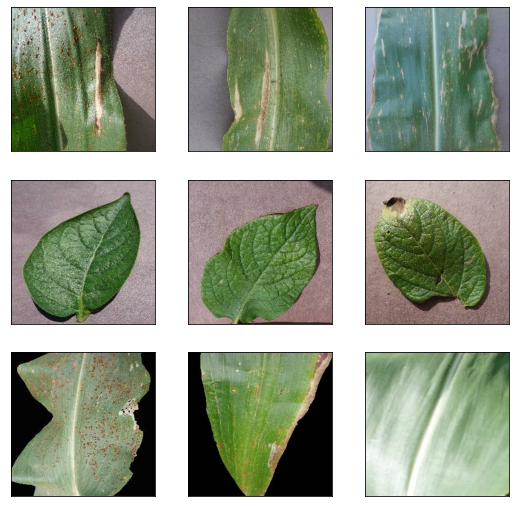

In [16]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Siamese Model

## Encoder using Xception model

In [17]:
def get_encoder(input_shape, dense_units=512, activation='relu'):
    """Returns the image encoding model with enhancements"""

    # Load Pretrained Model
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    print(len(pretrained_model.layers))
    for i in range(len(pretrained_model.layers) - 27):
        pretrained_model.layers[i].trainable = False

    # Build the encoding model
    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),

        layers.Dense(dense_units, activation=activation),
        layers.BatchNormalization(),

        layers.Dense(dense_units // 2, activation=activation),
        layers.BatchNormalization(),

        # L2 Normalization for output
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")

    return encode_model


## Distance Layer & Siamese Network

In [18]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(encoded_a, encoded_p, encoded_n)

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
siamese_network.summary()

83697664/83683744 [==============================] - 0s 0us/step
133
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22044968    Anchor_Input[0][0]               
               

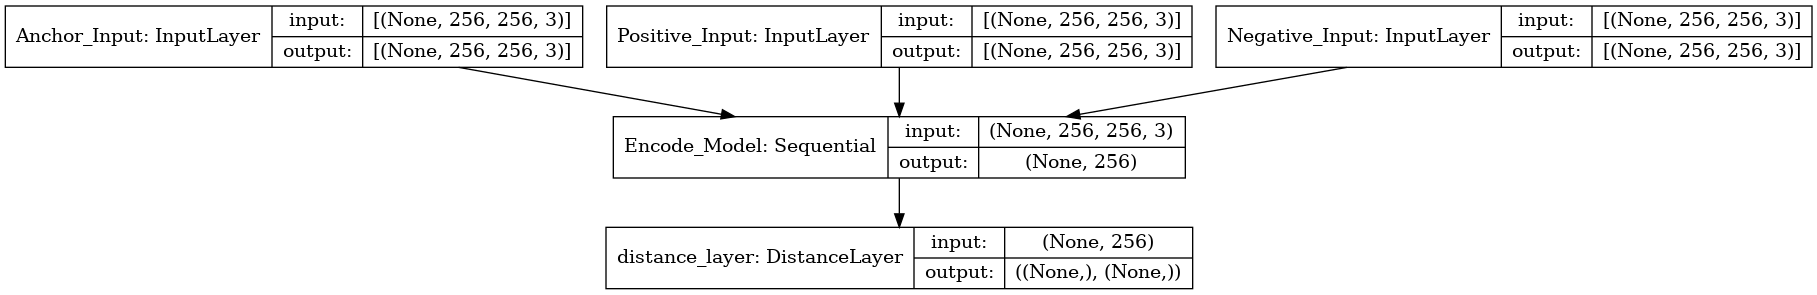

In [19]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Siamese Model Class

In [20]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [21]:
siamese_model = SiameseModel(siamese_network, margin=MARGIN)

In [22]:
siamese_model.compile(optimizer=Adam(learning_rate=0.001, epsilon=1e-01))

## Validation triplets accuracy function

In [23]:
def validate(dataset):
    pos_scores, neg_scores = [], []

    for data in dataset:
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    # print(f"Accuracy = {accuracy:.5f}")
    return accuracy

## Model callback to save the best weights

In [24]:
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras.models import Model

class AccuracyCheckpointCallback(Callback):
    def __init__(self, val_dataset, save_path='best_siamese_weights'):
        super().__init__()
        self.val_dataset = val_dataset
        self.save_path = save_path
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        # Calculate validation accuracy
        accuracy = validate(self.val_dataset)
        print(f"Epoch {epoch + 1}: Validation Accuracy = {accuracy:.5f}")

        # Check if this is the best accuracy so far
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.model.save_weights(self.save_path)
            print(f"Epoch {epoch + 1}: Best model saved with accuracy = {accuracy:.5f}")


accuracy_checkpoint_callback = AccuracyCheckpointCallback(val_dataset)

## load saved weights if the model trained before

In [25]:
if load_weights:
    dummy_input = tf.random.normal((1, *(IMAGE_SIZE, IMAGE_SIZE, 3)))
    siamese_model([dummy_input, dummy_input, dummy_input])
    siamese_model.load_weights(weights_path)
    print(f"{weights_path} loaded.")

/kaggle/working/siamese_model-final_93_84.weights.h5 loaded.


## Train the model

In [26]:
if Train:
    print('Training..')
    history = siamese_model.fit(
        train_dataset,
        epochs=5,
        validation_data=val_dataset,
        callbacks=[accuracy_checkpoint_callback]
    )

## Train & Validation triplets accuracy

In [27]:
validate(train_dataset)

0.9991064491064491

In [28]:
validate(val_dataset)

0.9306397306397306

## Extract Encoder Layers

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((IMAGE_SIZE, IMAGE_SIZE, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.summary()

133
Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)          

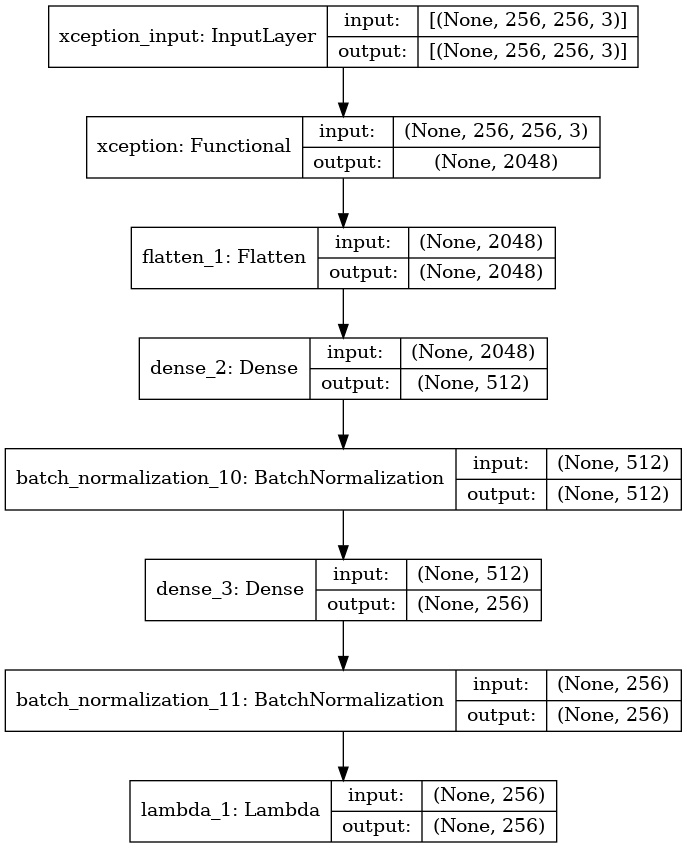

In [30]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

# Testing

## Convert image to tensor using the Encoder

In [31]:
def get_tensor(img_path):
  img = tf.data.Dataset.from_tensor_slices([img_path])
  img = tf.data.Dataset.zip(img)
  img = img.map(preprocess_image)
  img = img.prefetch(tf.data.AUTOTUNE)
  img = img.batch(1, drop_remainder=False)
  tensor = encoder.predict(img)
  return tensor

## Store a few training tensors for test comparison

In [32]:
tensors = {} # key is plant____disease, value is list[tensor1, tensor2, ... ]
def store_tensors():
  for disease, img_paths in train_images.items():
    tensors[disease] = []
    for path in img_paths[:compare_images]:
      tensors[disease].append(get_tensor(path))

store_tensors()

## Calculate the distance between two tensors

In [33]:
def get_distance(tensor1, tensor2):
  return np.sum(np.square(tensor1-tensor2), axis=-1)

## Predict disease of image using median

In [34]:
def predict_disease(img_path, plant_name):
  tensor_query = get_tensor(img_path)
  min_dis = 1e6
  dise = ""
  for disease in plant_disease[plant_name]:
    distance = []
    for tensor in tensors[disease]:
      distance.append(get_distance(tensor_query, tensor))
    distance = np.median(distance)
    if dise == "" or distance < min_dis:
      min_dis, dise = distance, disease
  return dise

## Predict plant from stage 1 model

# stage 1 classification model (Xception)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Sequential

def get_classification_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    for i in range(len(base_model.layers) - 27):
        base_model.layers[i].trainable = False

    # Add custom top layers
    Xception_model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(9, activation='softmax')  # Adjust num_classes to match your dataset
    ])

    # Compile the model
    Xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    Xception_model.load_weights(classification_model_path)
    return Xception_model

In [36]:
# model 1 predication
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

predicted_class = sorted(plant_disease.keys())
classification_model = get_classification_model()

def predict_plant(image_path):
    image = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = img_to_array(image) / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class
    prediction = classification_model.predict(image)
    predicted_label = predicted_class[np.argmax(prediction)]
    return predicted_label

print(predict_plant('/kaggle/input/plant-project-dataset/Project Data/Train/images/Apple___Apple_scab/18ea82fd-4e16-416f-8ad9-54e0f6601693___FREC_Scab 3127.JPG'))

Apple


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
unique_classes = sorted(list(train_images.keys()))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, predicted, num_classes=33):
    cm = confusion_matrix(actual, predicted, labels=unique_classes)
    cmap = sns.color_palette("Blues", as_cmap=True)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=unique_classes, yticklabels=unique_classes, cbar=False)
    for i in range(num_classes):
        cm[i, i] = cm[i, i] * 1.5  # Make correct predictions more prominent
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds", xticklabels=unique_classes, yticklabels=unique_classes, cbar=False)

    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()


## Test scenario 1

Total images = 1320
Correct Plants Predications = 1319
Accuracy Plants Predictions = 0.99924
Correct Disease Predications = 1227
Accuracy Disease Predictions = 0.92955


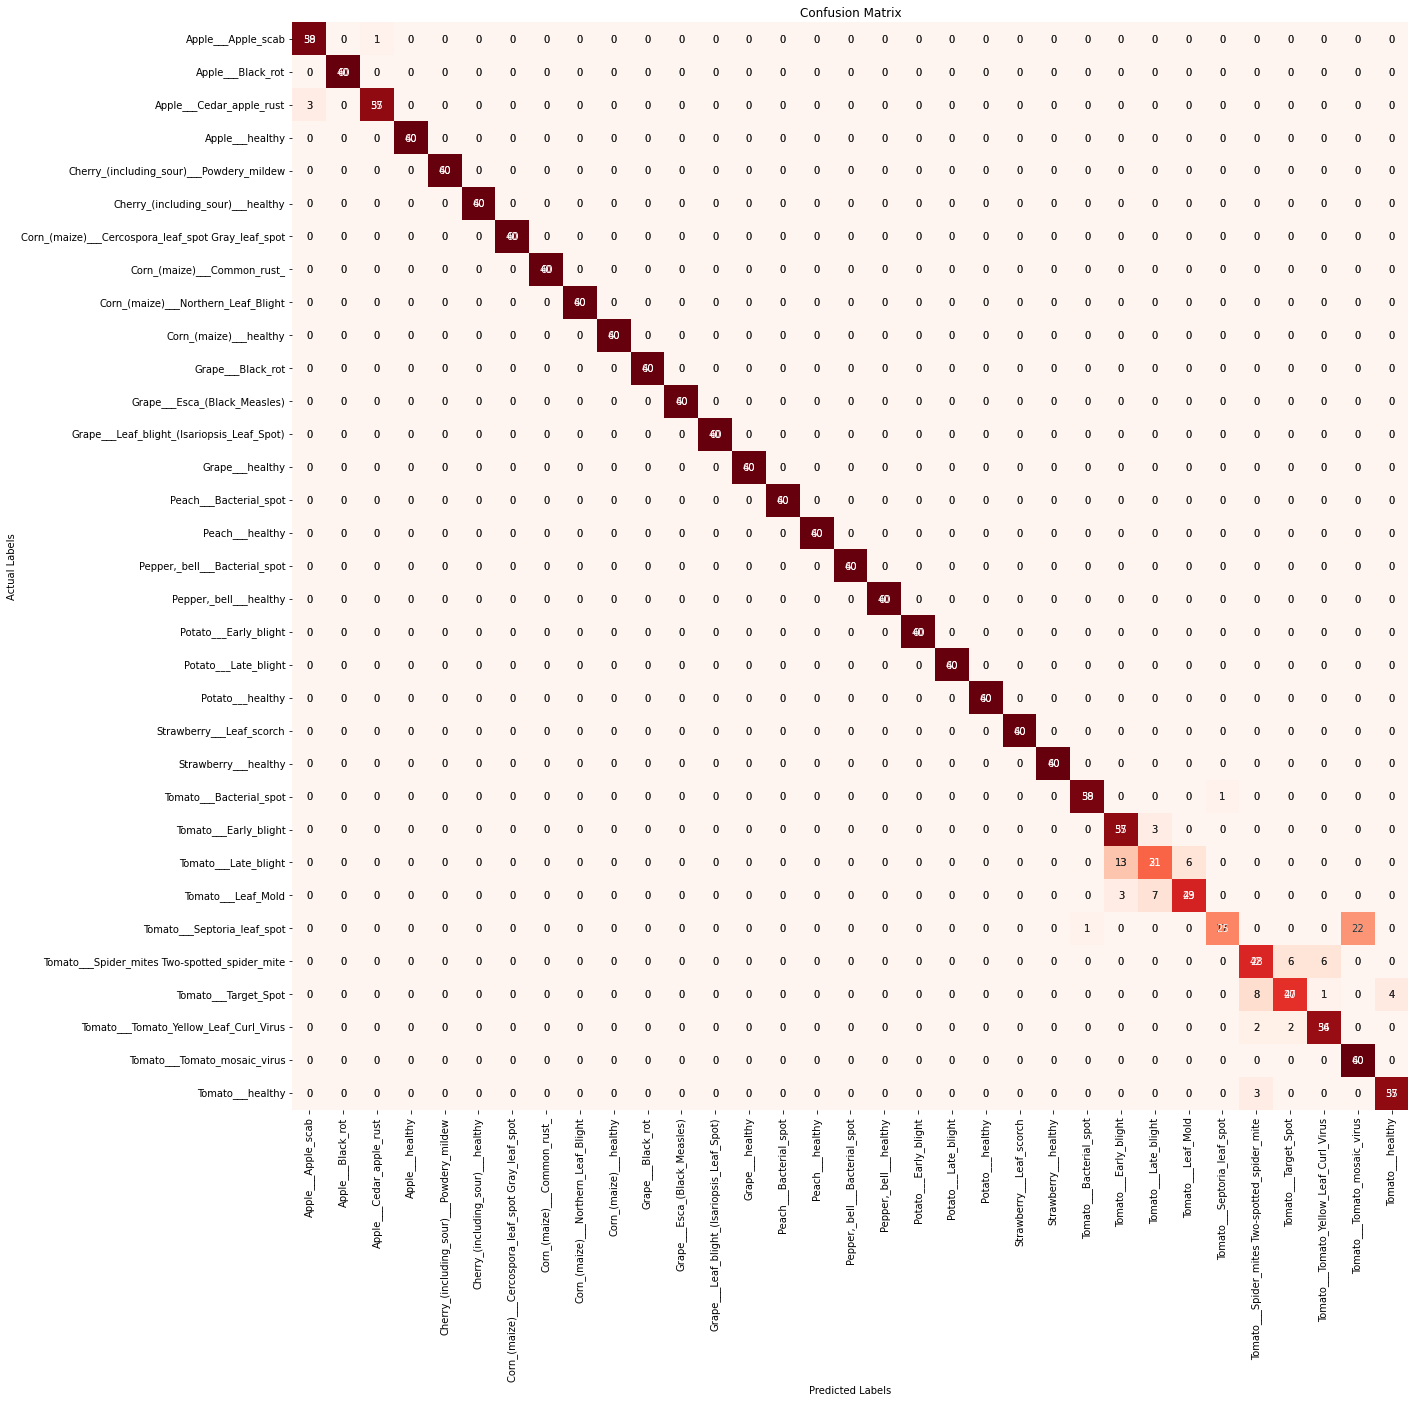

In [ ]:
def Test1(test_path, plot_conf_matrix=True):
    """
    Tests model on a dataset with images organized by plant and disease.

    - Predicts plant type, then disease based on predicted plant.
    - Calculates accuracy for both steps.
    - Optionally plots confusion matrices.
    """
    act = []
    pred = []
    correct_plant, correct_disease, total = 0, 0, 0
    for plant_disease_name in os.listdir(test_path):
        plant_actual = get_plant_name(plant_disease_name)
        disease_folder_path = os.path.join(test_path, plant_disease_name)
        images = os.listdir(disease_folder_path)
        for img in images:
            img_path = os.path.join(disease_folder_path, img)
            plant_pred = predict_plant(img_path) # predict the plant of img_path from stage_1 model
            if plant_pred == plant_actual:
                correct_plant += 1
                disease_pred = predict_disease(img_path, plant_pred)

                act.append(plant_disease_name)
                pred.append(disease_pred)

                if disease_pred == plant_disease_name:
                    correct_disease += 1
            total += 1

    print(f'Total images = {total}')
    print(f'Correct Plants Predications = {correct_plant}')
    print(f'Accuracy Plants Predictions = {(correct_plant / total):.5f}')

    print(f'Correct Disease Predications = {correct_disease}')
    print(f'Accuracy Disease Predictions = {(correct_disease / total):.5f}')
    if plot_conf_matrix:
        plot_confusion_matrix(act, pred)

Test1('/kaggle/input/plant-project-dataset/Project Data/Train/images')

Total images = 330
Correct Plants Predications = 330
Accuracy Plants Predictions = 1.00000
Correct Disease Predications = 279
Accuracy Disease Predictions = 0.84545


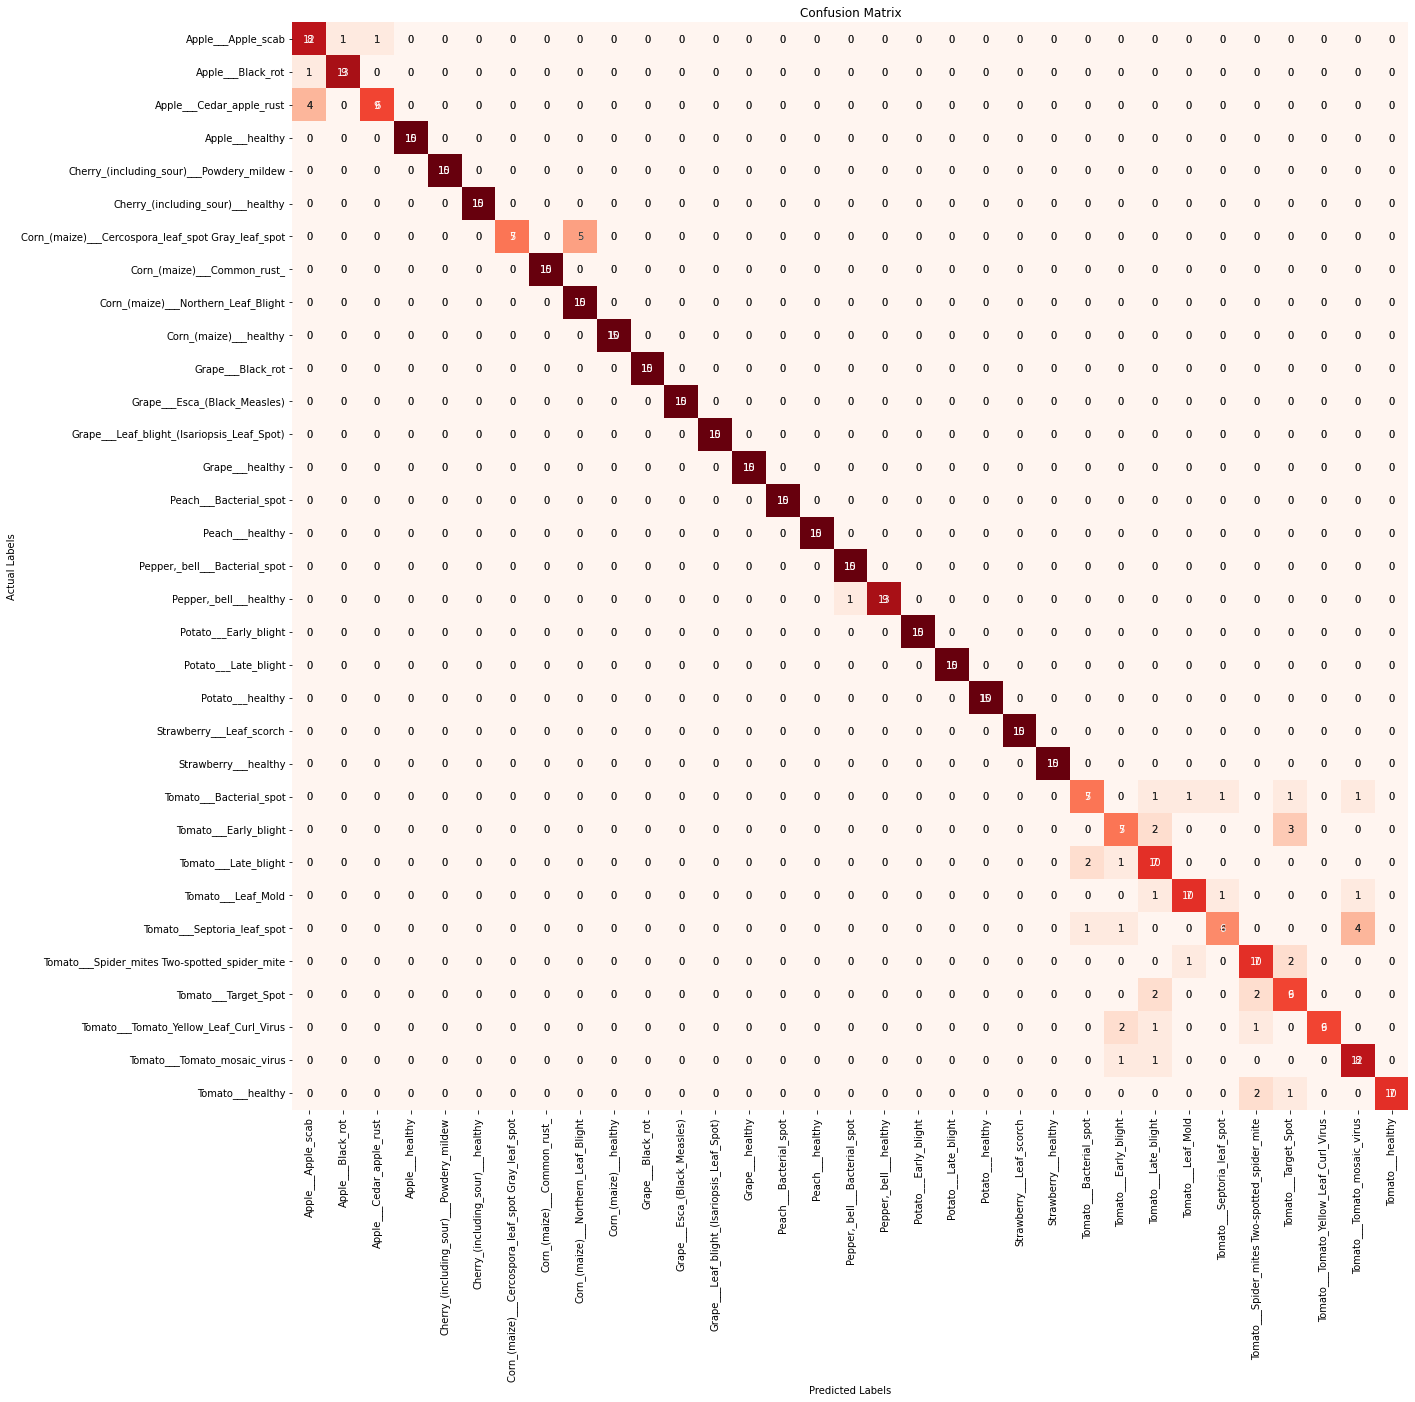

In [39]:
Test1('/kaggle/input/plant-project-dataset/Project Data/Val/images')

Total images = 33
Correct Plants Predications = 33
Accuracy Plants Predictions = 1.00000
Correct Disease Predications = 25
Accuracy Disease Predictions = 0.75758


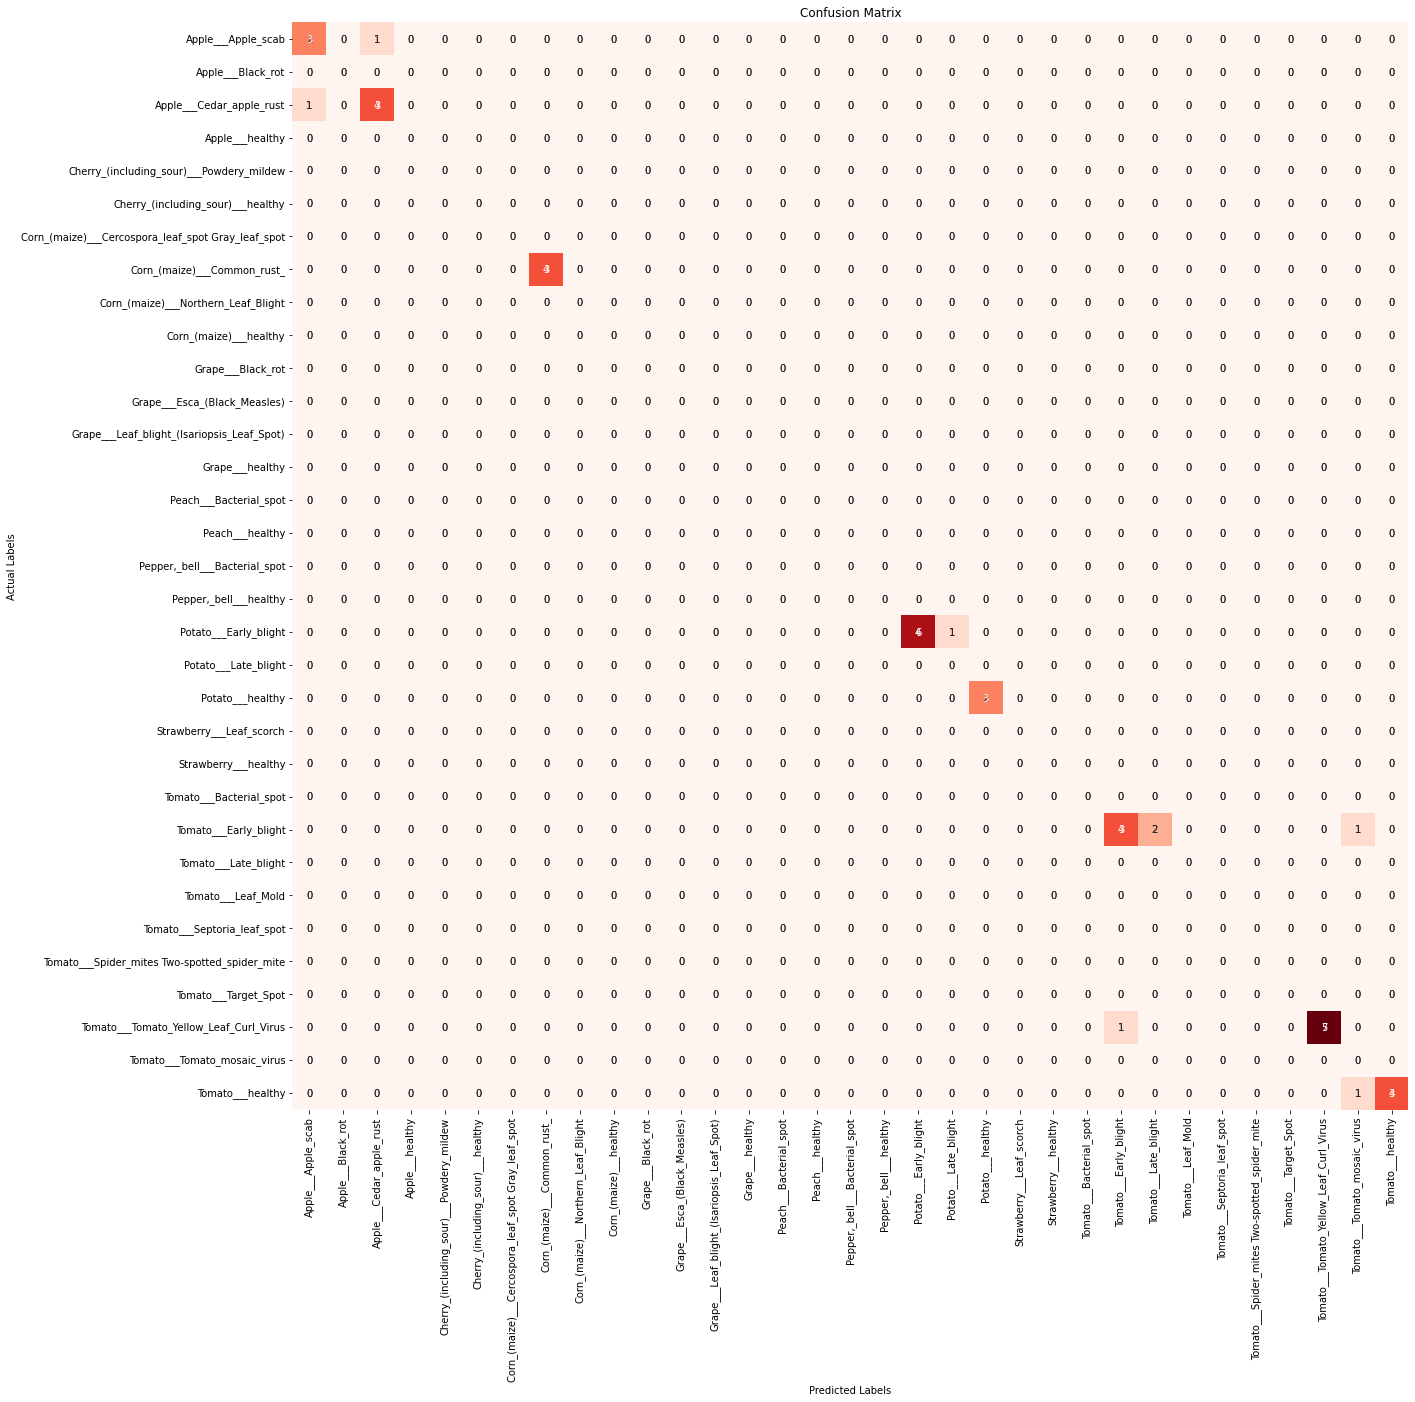

In [40]:
Test1('/kaggle/input/plants-test-data-1/test_data')

## Test scenario 2

In [ ]:
def Test2(test_path, img_name='Anchor.jpg'):
  """
  Finds the most similar image to 'img_name' in a folder of shuffled plant images.
  """
  anchor = os.path.join(test_path, img_name)
  print(anchor)
  anchor_tensor = get_tensor(anchor)
  match_image = ""
  min_dis = 0

  for img in os.listdir(test_path):
    if img == img_name:
      continue
    img_path = os.path.join(test_path, img)
    img_tensor = get_tensor(img_path)
    dis = get_distance(anchor_tensor, img_tensor)
    if match_image == "" or dis < min_dis:
      match_image, min_dis = img, dis
  print(f'Matched image: {match_image}')
  return match_image

test_folder = '/kaggle/input/plants-test-data-2/test_data2'
for img in os.listdir(test_folder):
    print(img)
    Test2(test_folder, img)
    print()

squash_1.jpg
/kaggle/input/plants-test-data-2/test_data2/squash_1.jpg
Matched image: Rasberry_1.jpg

soybean_1.jpg
/kaggle/input/plants-test-data-2/test_data2/soybean_1.jpg
Matched image: blueberry_2.jpg

soybean.jpg
/kaggle/input/plants-test-data-2/test_data2/soybean.jpg
Matched image: blueberry_1.jpg

Raspberry_2.jpg
/kaggle/input/plants-test-data-2/test_data2/Raspberry_2.jpg
Matched image: Rasberry_1.jpg

blueberry_2.jpg
/kaggle/input/plants-test-data-2/test_data2/blueberry_2.jpg
Matched image: soybean_1.jpg

orange_2.jpg
/kaggle/input/plants-test-data-2/test_data2/orange_2.jpg
Matched image: orange_1.jpg

squash_2.jpg
/kaggle/input/plants-test-data-2/test_data2/squash_2.jpg
Matched image: blueberry_1.jpg

orange_1.jpg
/kaggle/input/plants-test-data-2/test_data2/orange_1.jpg
Matched image: orange_2.jpg

blueberry_1.jpg
/kaggle/input/plants-test-data-2/test_data2/blueberry_1.jpg
Matched image: soybean.jpg

Rasberry_1.jpg
/kaggle/input/plants-test-data-2/test_data2/Rasberry_1.jpg
Matc